In [1]:
from simformer import *
import matplotlib.pyplot as plt
import matplotlib.animation

import numpy as np
import torch
import os

%matplotlib inline

# Load data

In [ ]:
# --- Load in training data ---
path_training = os.getcwd() + '/simformer/data/chempy_TNG_train_data.npz'
training_data = np.load(path_training, mmap_mode='r')

elements = training_data['elements']
train_x = training_data['params']
train_y = training_data['abundances']


# ---  Load in the validation data ---
path_test = os.getcwd() + '/simformer/data/chempy_TNG_val_data.npz'
val_data = np.load(path_test, mmap_mode='r')

val_x = val_data['params']
val_y = val_data['abundances']


# --- Clean the data ---
# Chempy sometimes returns zeros or infinite values, which need to removed
def clean_data(x, y):
    # Remove all zeros from the training data
    index = np.where((y == 0).all(axis=1))[0]
    x = np.delete(x, index, axis=0)
    y = np.delete(y, index, axis=0)

    # Remove all infinite values from the training data
    index = np.where(np.isfinite(y).all(axis=1))[0]
    x = x[index]
    y = y[index]

    # Remove H from Elements
    y = np.delete(y, 2, 1)

    return x, y


train_x, train_y = clean_data(train_x, train_y)
val_x, val_y     = clean_data(val_x, val_y)

# convert to torch tensors
train_x = torch.tensor(train_x, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.float32)
val_x = torch.tensor(val_x, dtype=torch.float32)
val_y = torch.tensor(val_y, dtype=torch.float32)

train_data = torch.cat((train_x, train_y), 1)
val_data = torch.cat((val_x, val_y), 1)

In [3]:
# Define the simformer

# Time steps for the diffusion process
T = 300
t = torch.linspace(0, 1, T)

simformer = Simformer(T, train_data.shape)

/export/home/bguenes/anaconda3/envs/simformer_torch/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [4]:
train_data.shape

torch.Size([498314, 14])

In [5]:
val_data.shape

torch.Size([49824, 14])

In [6]:
simformer.train_loss

AttributeError: 'Simformer' object has no attribute 'train_loss'

In [7]:
simformer.train(train_data, condition_mask_data=torch.ones_like(train_data), val_data=val_data, condition_mask_val=torch.ones_like(val_data))

Epoch  0 -- Training Loss: 36418371.335 -- Validation Loss: 2632880.000
Epoch  1 -- Training Loss: 24562646.496 -- Validation Loss: 2634526.500
Epoch  2 -- Training Loss: 23485246.845 -- Validation Loss: 2282727.750
Epoch  3 -- Training Loss: 22779430.676 -- Validation Loss: 2126495.500
Epoch  4 -- Training Loss: 22377344.563 -- Validation Loss: 2103593.500
Epoch  5 -- Training Loss: 22101343.652 -- Validation Loss: 2252788.000
Epoch  6 -- Training Loss: 21992040.928 -- Validation Loss: 2117207.500
Epoch  7 -- Training Loss: 22061955.096 -- Validation Loss: 2241369.000
Epoch  8 -- Training Loss: 21822069.985 -- Validation Loss: 2085958.375
Epoch  9 -- Training Loss: 21770858.848 -- Validation Loss: 2186309.500


In [8]:
simformer.train_loss

[36418371.33496094,
 24562646.496276855,
 23485246.845489502,
 22779430.675567627,
 22377344.563476562,
 22101343.6517334,
 21992040.92755127,
 22061955.095947266,
 21822069.985168457,
 21770858.848251343]

In [11]:
val_data.shape

torch.Size([49824, 14])

In [17]:
simformer.state_dict()

OrderedDict([('condition_embedding',
              tensor([[[-0.0042, -0.4096,  1.6220,  0.4540,  0.0108, -1.2007, -1.8754,
                         0.1230, -0.9162, -0.7652]]])),
             ('embedding_net_id.weight',
              tensor([[ 2.7044e+00, -2.9731e+00,  3.6707e-01, -6.1422e-01,  4.4323e-01,
                       -1.4969e+00, -1.9308e+00, -9.1281e-01,  1.3079e+00, -1.0661e+00,
                        3.9415e-01,  1.5416e+00, -1.7941e-01, -2.8646e-02, -2.9874e-03,
                        2.3855e+00, -2.9968e-01,  6.5597e-01,  7.6617e-02, -2.3490e+00],
                      [-1.3915e+00, -3.2998e+00, -3.3565e-01, -1.2951e+00, -1.8697e-01,
                       -6.9875e-01, -5.2980e-01,  9.0647e-01,  1.1269e+00, -4.3620e+00,
                       -3.2998e-01,  4.0516e-01,  1.3936e+00, -3.0149e-01,  1.4905e+00,
                        7.2194e-01,  2.0611e+00, -2.9948e-01,  1.3173e+00,  9.5620e-02],
                      [ 1.6519e+00, -7.4518e-01, -5.2456e-01, -5.2418e-01

In [ ]:
torch.save(simformer.state_dict(), "simformer/models/simformer.pt")

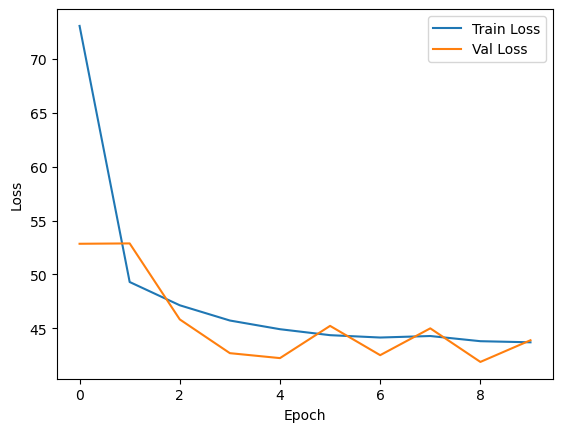

In [15]:
epoch = np.arange(0, len(simformer.train_loss))

plt.plot(epoch, np.array(simformer.train_loss)/train_data.shape[0], label='Train Loss')
plt.plot(epoch, np.array(simformer.val_loss)/val_data.shape[0], label='Val Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
plt.plot(t, simformer.sde.marginal_prob_std(t))
plt.title("Marginal probability standard deviation")
plt.xlabel("Time")
plt.show()

In [27]:
simformer.sample()

TypeError: Simformer.sample() missing 2 required positional arguments: 'data' and 'condition_mask'

# Animate Diffusion Process
Diffusion process to create the data for score training.

In [ ]:
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, ax = plt.subplots()

t = torch.linspace(0, 1, T)
color = ['red', 'blue', 'green', 'purple', 'orange', 'black']

def animate(i):
    data_t = simformer.forward_diffusion_sample(data[:,:6], t[i])
    plt.cla()
    for n in range(data_t.shape[1]):
        plt.hist(data_t[:,n], bins=500, range=(-5,15), density=True, alpha=0.5, color=color[n])
    plt.xlim([-5,15])
    plt.ylim([0,1])
    plt.title(f"t={int(i)}")

"""
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=299)

writer = matplotlib.animation.PillowWriter(fps=20,
                                metadata=dict(artist='Me'),
                                bitrate=1800)
ani.save('../plots/theta_to_noise.gif', writer=writer)
"""
matplotlib.animation.FuncAnimation(fig, animate, frames=10)

In [ ]:
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, ax = plt.subplots()

t = torch.linspace(0, 1, T)

def animate2(i):
    data_t = simformer.forward_diffusion_sample(data[:,7:], t[i])
    plt.cla()
    for n in range(data_t.shape[1]):
        plt.hist(data_t[:,n], bins=500, range=(-2,2), density=True, alpha=0.5)
    plt.xlim([-2,2])
    plt.ylim([0,2.5])
    plt.title(f"t={int(i)}")

ani2 = matplotlib.animation.FuncAnimation(fig, animate2, frames=299) 

writer = matplotlib.animation.PillowWriter(fps=20,
                                metadata=dict(artist='Me'),
                                bitrate=1800)
ani2.save('../plots/x_to_noise.gif', writer=writer)

# Transformer forward pass

In [ ]:
torch.ones(data[:10].shape[0],1)*10

In [ ]:
score = simformer.forward_transformer(data[:10], torch.ones(data[:10].shape[0],1)*10, condition_mask=torch.ones_like(data[:10]))

In [ ]:
score.shape

In [ ]:
score